In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import cosmology
from astropy import table
from astropy import units as u
from astropy.io import fits
from astropy import coordinates

from ekfplot import plot as ek
from ekfstats import functions

from agrias import utils

import reader 

cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [3]:
import sys
sys.path.append('/Users/kadofong/work/projects/SAGAbg/scripts/')
import catalogs

In [4]:
cd ~/work/projects/SAGAbg/scripts/

/Users/kadofong/work/projects/SAGAbg/scripts


In [5]:
asb, logmstar = catalogs.load_singleton_catalog('ASB')

SAGA `shared_dir` set to /Users/kadofong/DropBox/SAGA/
SAGA `local_dir`  set to ../local_data/


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/SAGA/utils/functions.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table[c][mask] = v
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/SAGA/utils/functions.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table[c][mask] = v
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/SAGA/utils/functions.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [6]:
cd ~/work/projects/merian/agrias/notebooks

/Users/kadofong/work/projects/merian/agrias/notebooks


In [7]:
saga_lha_df = pd.read_csv('/Users/kadofong/Desktop/saga_lha.csv', index_col=0)

In [8]:
gama = table.Table(fits.open('/Users/kadofong/work/projects/gama/local_data/SersicCatSDSSv09.fits')[1].data)

In [9]:
#saga = np.genfromtxt('/Users/kadofong/Desktop/ref.txt')
saga_coords = coordinates.SkyCoord(asb['RA'],asb['DEC'],unit='deg')

In [10]:
gama_coords = coordinates.SkyCoord(gama['RA'],gama['DEC'],unit='deg')

In [11]:
merian_sources, galex = reader.get_meriancrossgalex ()

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [12]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)
merian_lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)
merian_lha_df = merian_lha_df.reindex(merian_sources.index)

In [13]:
merian_coords = coordinates.SkyCoord(merian_sources['RA'],merian_sources['DEC'],unit='deg')

In [14]:
idx,d2d,_= merian_coords.match_to_catalog_sky(gama_coords)
is_match = d2d < (2. * u.arcsec)

In [15]:
idx_saga, d2d_saga, _ = saga_coords.match_to_catalog_sky(gama_coords)
is_match_saga = d2d_saga <  (2.*u.arcsec)

In [16]:
idx_sm, d2d_sm, _ = merian_coords.match_to_catalog_sky(saga_coords)
is_match_sm = d2d_sm < (2.*u.arcsec)

-0.016688924846783637

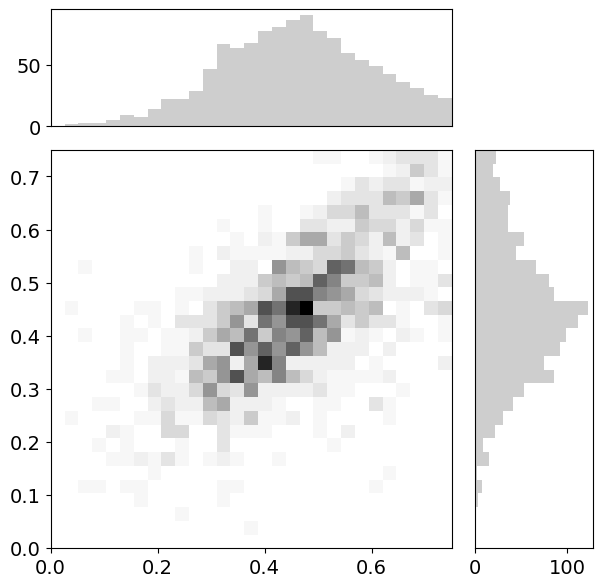

In [17]:
gama_mag = gama[idx[is_match]]['GALMAG_g'].value - gama[idx[is_match]]['GALMAG_r'].value
merian_mag = -2.5*np.log10(merian_sources.loc[is_match, utils.photcols['g']]/merian_sources.loc[is_match, utils.photcols['r']])
gama_mag, merian_mag = functions.finite_masker([gama_mag,merian_mag], inplace=True, ul=10, ll=-10.)

out, axarr=ek.hist2d(
    gama_mag,
    merian_mag,
    bins=[np.linspace(0.,0.75,30),np.linspace(0.,0.75,30)],
    show_proj=True
)
np.nanmedian(merian_mag-gama_mag)

Text(0, 0.5, 'g-r (SAGA)')

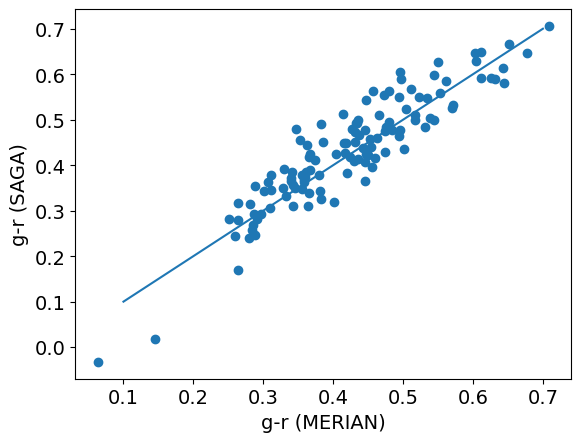

In [18]:
xf = asb.reindex(asb.index[idx_sm[is_match_sm]])
saga_mag = xf['g_mag'] -  xf['r_mag']
saga_mag = saga_mag.values
merian_mag = -2.5*np.log10(merian_sources.loc[is_match_sm, utils.photcols['g']]/merian_sources.loc[is_match_sm, utils.photcols['r']])
saga_mag, merian_mag = functions.finite_masker([saga_mag,merian_mag], inplace=True, ul=10., ll=-10.)

plt.scatter(
    saga_mag,
    merian_mag,
)
xs = [0.1,0.7]
plt.plot(xs,xs)
np.nanmedian(merian_mag-saga_mag)
plt.xlabel('g-r (MERIAN)')
plt.ylabel('g-r (SAGA)')

0.0977750389475503


Text(0, 0.5, 'r-z (SAGA)')

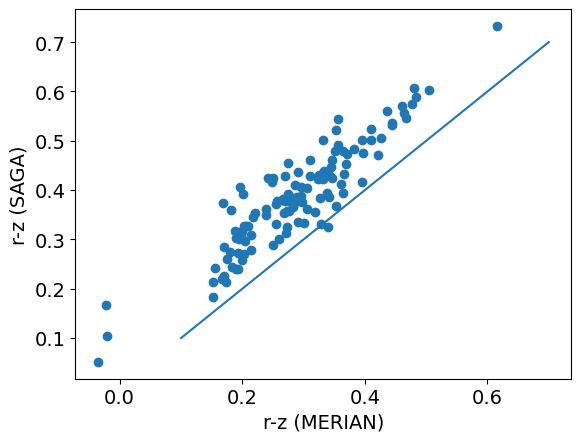

In [19]:
saga_mag = (xf['r_mag'] -  xf['z_mag']).values
merian_mag = -2.5*np.log10(merian_sources.loc[is_match_sm, utils.photcols['r']]/merian_sources.loc[is_match_sm, utils.photcols['z']])
saga_mag, merian_mag = functions.finite_masker([saga_mag,merian_mag], inplace=True, ul=10., ll=-10.)

plt.scatter(
    saga_mag,
    merian_mag,
)
xs = [0.1,0.7]
plt.plot(xs,xs)
print(np.nanmedian(merian_mag-saga_mag))
plt.xlabel('r-z (MERIAN)')
plt.ylabel('r-z (SAGA)')

0.023400699278385062


Text(0, 0.5, 'm$_z$ (SAGA)')

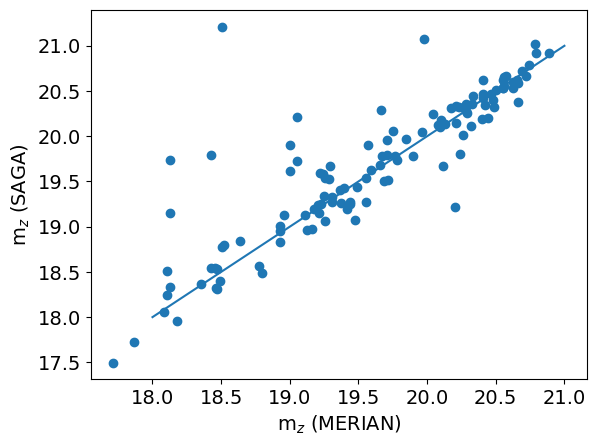

In [20]:
band = 'r'
saga_mag = xf[f'{band}_mag'].values

apercorr = merian_sources['i_cModelFlux_Merian']/merian_sources['i_gaap1p0Flux_Merian']
flux = merian_sources.loc[:,utils.photcols[band]]*apercorr

merian_mag = -2.5*np.log10(flux.loc[is_match_sm]) + 31.4
saga_mag, merian_mag = functions.finite_masker([saga_mag,merian_mag], inplace=True, ul=30,ll=3.)

plt.scatter(
    saga_mag,
    merian_mag,
)
#xs = [0.1,0.7]
xs = [18.,21.]
plt.plot(xs,xs)
print(np.nanmedian(merian_mag-saga_mag))
plt.xlabel(r'm$_z$ (MERIAN)')
plt.ylabel(r'm$_z$ (SAGA)')

In [23]:
saga_halum = saga_lha_df.reindex(asb.index[idx_sm[is_match_sm]])['LHa_50']
#merian_halum = catalog_halum.loc[is_match_sm, 'LHa']

merian_halum = merian_lha_df.loc[is_match_sm,'LHa']*1e40

Text(0, 0.5, 'L(Ha) Merian catalog, corrected')

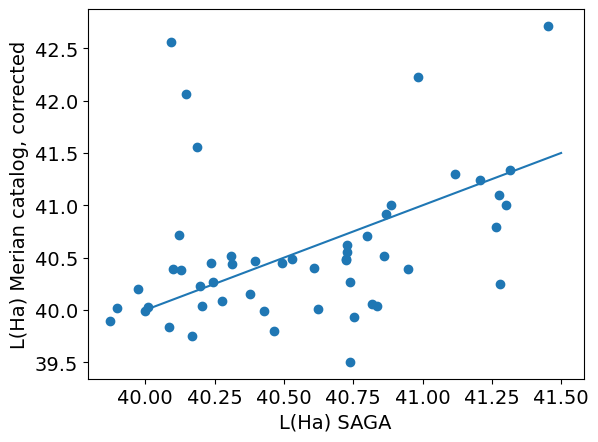

In [27]:
plt.scatter(
    np.log10(saga_halum),
    np.log10(merian_halum) 
)
xs = np.array([40.,41.5])
plt.plot(xs,xs)
plt.xlabel('L(Ha) SAGA')
plt.ylabel('L(Ha) Merian catalog, corrected')

In [63]:
from carpenter import conventions

In [75]:
highew = catalog_halum.sort_values('LHa', ascending=False)

_ = merian_sources.reindex(highew.index.intersection(merian_lha_df["LHa"].dropna().index)).iloc[:10]
[ conventions.produce_merianobjectname(x['RA'], x['DEC']) for name,x in _.iterrows() ]

['J115412.77+012151.08',
 'J100540.66+035814.08',
 'J095442.25+033025.66',
 'J090932.34+002424.87',
 'J112811.73-005014.42',
 'J095513.27+002918.20',
 'J114437.51-010839.14',
 'J094020.53-012842.00',
 'J083514.95-000036.11',
 'J101314.58+013453.92']

In [78]:
_[['RA','DEC','z_phot','z_spec','logmass_gaap1p0']]

,RA,DEC,z_phot,z_spec,logmass_gaap1p0
M3416670810662796115,178.553193,1.364188,0.071659,0.077040,9.192100
M3582591513340703553,151.419408,3.970578,0.080193,NaN,9.172126
M3581791068875682947,148.676031,3.507127,0.078243,0.072523,11.787655
M3406489332989592377,137.384748,0.406908,0.082561,0.093530,9.496127
M3328142532440784613,172.048894,-0.837339,0.070636,NaN,9.027940
M3408996219500907006,148.805279,0.488390,0.071168,0.071531,8.568990
M3329180471417399648,176.156298,-1.144207,0.082656,0.078230,10.324791
M3321620229464822403,145.085549,-1.478333,0.080956,NaN,9.303469
M3318013831325696798,128.812279,-0.010030,0.082683,NaN,8.789243
M3496570121630009849,153.310759,1.581645,0.085542,0.071376,10.102180
